In [85]:
from functools import reduce
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [96]:
def euler_to_mat2(x, y, z):
    """
    按照 zyx 的顺序旋转，输入角度单位为 degrees, 均为顺时针旋转
    :param x: X-axis
    :param y: Y-axis
    :param z: Z-axis
    :return:
    """
    z = math.radians(z)
    y = math.radians(y)
    x = math.radians(x)

    c, s = math.cos(y), math.sin(y)
    M_y = np.matrix([[c, 0., s, 0.],
                     [0., 1., 0., 0.],
                     [-s, 0., c, 0.],
                     [0., 0., 0., 1.]])

    c, s = math.cos(x), math.sin(x)
    M_x = np.matrix([[1., 0., 0., 0.],
                     [0., c, -s, 0.],
                     [0., s, c, 0.],
                     [0., 0., 0., 1.]])

    c, s = math.cos(z), math.sin(z)
    M_z = np.matrix([[c, -s, 0., 0.],
                     [s, c, 0., 0.],
                     [0., 0., 1., 0.],
                     [0., 0., 0., 1.]])

    return M_x * M_y * M_z

In [95]:
def getPoints_for_PerspectiveTranformEstimation(ptsIn, ptsOut, W, H, sidelength):
    
    ptsIn2D      =  ptsIn[0,:]
    ptsOut2D     =  ptsOut[0,:]
    ptsOut2Dlist =  []
    ptsIn2Dlist  =  []
    
    for i in range(0,4):
        ptsOut2Dlist.append([ptsOut2D[i,0], ptsOut2D[i,1]])
        ptsIn2Dlist.append([ptsIn2D[i,0], ptsIn2D[i,1]])
    
    pin  =  np.array(ptsIn2Dlist)   +  [W/2.,H/2.]
    pout = (np.array(ptsOut2Dlist)  +  [1.,1.]) * (0.5*sidelength)
    pin  = pin.astype(np.float32)
    pout = pout.astype(np.float32)
    
    return pin, pout

In [161]:
def warpMatrix(W, H, theta, phi, gamma, scale, fV):
    
    # M is to be estimated
    M          = np.eye(4, 4)
    
    fVhalf     = np.deg2rad(fV/2.)
    d          = np.sqrt(W*W+H*H)
    sideLength = scale*d/np.cos(fVhalf)
    h          = d/(2.0*np.sin(fVhalf))
    n          = h-(d/2.0);
    f          = h+(d/2.0);
    
    # Translation along Z-axis by -h
    T       = np.eye(4,4)
    T[2,3]  = -h
    
    # Rotation matrices around x,y,z
    R = euler_to_mat2(phi, gamma, theta)
    
    # Projection Matrix 
    P       = np.eye(4,4)
    P[0,0]  = 1.0/np.tan(fVhalf)
    P[1,1]  = P[0,0]
    P[2,2]  = -(f+n)/(f-n)
    P[2,3]  = -(2.0*f*n)/(f-n)
    P[3,2]  = -1.0
    
    # pythonic matrix multiplication
    F       = reduce(lambda x,y : np.matmul(x,y), [P, T, R]) 

    # shape should be 1,4,3 for ptsIn and ptsOut since perspectiveTransform() expects data in this way. 
    # In C++, this can be achieved by Mat ptsIn(1,4,CV_64FC3);
    ptsIn = np.array([[
                 [-W/2., H/2., 0.],[ W/2., H/2., 0.],[ W/2.,-H/2., 0.],[-W/2.,-H/2., 0.]
                 ]])
    ptsOut  = np.array(np.zeros((ptsIn.shape), dtype=ptsIn.dtype))
    ptsOut  = cv2.perspectiveTransform(ptsIn, F)
    
    ptsInPt2f, ptsOutPt2f = getPoints_for_PerspectiveTranformEstimation(ptsIn, ptsOut, W, H, sideLength)
    
    # check float32 otherwise OpenCV throws an error
    assert(ptsInPt2f.dtype  == np.float32)
    assert(ptsOutPt2f.dtype == np.float32)
    M33 = cv2.getPerspectiveTransform(ptsInPt2f,ptsOutPt2f)

    return M33, sideLength, ptsOutPt2f

In [150]:
def warpImage(src,theta, phi,gamma,scale,fovy,corners=None):
    H,W,Nc    = src.shape
    M,sl,ptsOut      = warpMatrix(W,H, theta,phi,gamma, scale,fovy);          #Compute warp matrix
    sl = int(sl)
    dst = cv2.warpPerspective(src,M, (sl,sl));                  #Do actual image warp
    cv2.line(dst, (ptsOut[0][0],ptsOut[0][1]), (ptsOut[1][0],ptsOut[1][1]), color=(255,0,0), thickness=2)
    cv2.line(dst, (ptsOut[1][0],ptsOut[1][1]), (ptsOut[2][0],ptsOut[2][1]), color=(255,0,0), thickness=2)
    cv2.line(dst, (ptsOut[2][0],ptsOut[2][1]), (ptsOut[3][0],ptsOut[3][1]), color=(255,0,0), thickness=2)
    cv2.line(dst, (ptsOut[3][0],ptsOut[3][1]), (ptsOut[0][0],ptsOut[0][1]), color=(255,0,0), thickness=2)
    return dst

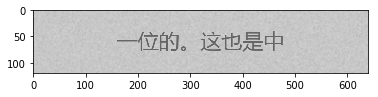

In [97]:
src    = cv2.imread('text.jpg')
src    = src[...,::-1] # BGR to RGB
H,W,Nc = src.shape
plt.imshow(src)

Output image dimension = (674, 674, 3)


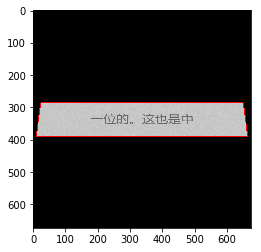

In [162]:
# theta: z 轴旋转
# phi: x 轴旋转
# gamma: y 轴旋转
imgwarped = warpImage(src, 0, 30, 0, 1., 30)
cv2.imwrite("imgwarped.jpg", imgwarped)
print('Output image dimension = {}'.format(imgwarped.shape))
plt.imshow(imgwarped)